In [1]:
import os
import glob
import grizli
import grizli.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
from scipy import constants
from matplotlib.colors import LogNorm

In [2]:
# Spectra tools
import pysynphot as S
import webbpsf

/Users/ross.1333/anaconda3/envs/grizli39/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/ross.1333/pysyn_cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/ross.1333/anaconda3/envs/grizli39/lib/python3.9/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ross.1333/pysyn_cdbs/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/ross.1333/anaconda3/envs/grizli39/lib/python3.9/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ross.1333/pysyn_cdbs/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '
**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-068
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or co

In [4]:
#copying from https://github.com/keithbuckholz/summer-roman-project/blob/master/psf/notebooks/psf_exploration.ipynb to simulate star images

In [3]:
webbpsf.roman

<module 'webbpsf.roman' from '/Users/ross.1333/anaconda3/envs/grizli39/lib/python3.9/site-packages/webbpsf/roman.py'>

In [4]:
wfi = webbpsf.roman.WFI()
wfi.filter = "GRISM0"

In [5]:
#fiducial zero point set based on 2022 sim below
def mag2flux(mag,zp=26.5):
    f0 = 10**(0.4*zp)
    flux = f0*10**(-0.4*mag) #mag = 26.5 - 2.5*np.log10(sumflux)
    return flux

In [8]:
mag2flux(16)

15848.931924611174

In [6]:
def star_postage(mag,detx=2044,dety=2044,offx=0,offy=0,wavelength = 1.5e-6, fov_pixels=364, oversample=2):
    arcperpixel = 0.11
    wfi.options['source_offset_x'] = offx*arcperpixel
    wfi.options['source_offset_y'] = offy*arcperpixel
    wfi.detector_position = (detx, dety)
    psf = wfi.calc_psf(monochromatic=wavelength, fov_pixels=fov_pixels, oversample=oversample)
    flux = mag2flux(mag)
    return psf[0].data*flux

In [12]:
fov_pixels = 364
pad = fov_pixels + 1
stars00 = Table.read('/Users/ross.1333/Documents/GitHub/star_fields/py/stars_radec00.ecsv')
sel_ondet = stars00['Xpos'] < 4088
sel_ondet &= stars00['Ypos'] < 4088
stars00 = stars00[sel_ondet]
Ntot= len(stars00)
print(Ntot)


409


In [8]:
sp = star_postage(18,0,0,0,0,fov_pixels=fov_pixels)

Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (10.879642720575857, 0.0026943146905864523)


In [31]:
sp.shape

(728, 728)

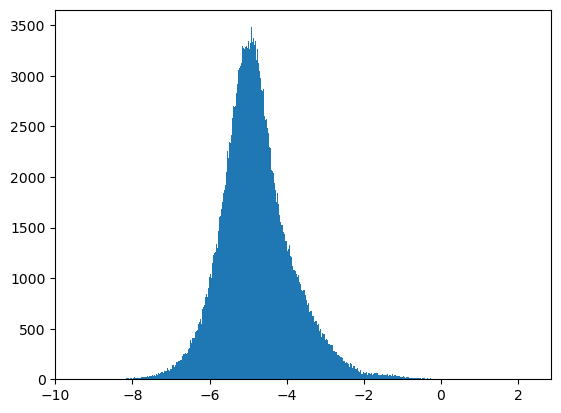

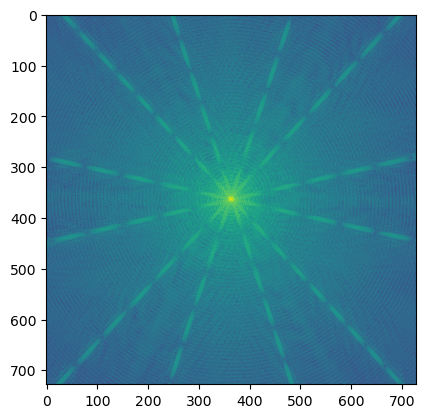

In [ ]:
plt.hist(np.log10(sp.flatten()),bins=1000)
plt.show()
plt.imshow(np.log10(sp))#,vmin=1e-2)

In [8]:
full_image = np.zeros((4088+2*pad,4088+2*pad))
full_seg = np.zeros((4088+2*pad,4088+2*pad),dtype=int)
thresh = 0.01 #threshold flux for segmentation map
N = 0
for i in range(0,len(stars00)):
    xpos = stars00[i]['Xpos']
    ypos = stars00[i]['Ypos']
    mag = stars00[i]['magnitude']
    if xpos < 4088 and ypos < 4088:
        xp = int(xpos)
        yp = int(ypos)
        xoff = 0#xpos-xp
        yoff = 0#ypos-yp
        sp = star_postage(mag,xpos,ypos,xoff,yoff,fov_pixels=fov_pixels)
        full_image[xp+pad-fov_pixels:xp+pad+fov_pixels,yp+pad-fov_pixels:yp+pad+fov_pixels] += sp
        selseg = sp > thresh
        seg = np.zeros((len(sp),len(sp)),dtype=int)
        seg[selseg] = i+1
        #set instead of add; any blends end up being last added source
        #but, then go back and return the values that got set to zero back to their original values
        full_segold = np.copy(full_seg)
        full_seg[xp+pad-fov_pixels:xp+pad+fov_pixels,yp+pad-fov_pixels:yp+pad+fov_pixels] = seg 
        sel = full_seg != i+1
        full_seg[sel] = full_segold[sel]
        N += 1
        if N//10 == N/10:
            print(N,Ntot,len(np.unique(full_seg)))

Attempted to get aberrations at field point (1562, 3950) which is outside the range of the reference data; approximating to nearest interpolated point (1561.6033353832906, 3550.459564819674)
Attempted to get aberrations at field point (2507, 3988) which is outside the range of the reference data; approximating to nearest interpolated point (2506.564677493309, 3549.521405135276)


10 409 11


Attempted to get aberrations at field point (1837, 3710) which is outside the range of the reference data; approximating to nearest interpolated point (1836.8413366174543, 3550.1863079308837)


20 409 21


Attempted to get aberrations at field point (3438, 3668) which is outside the range of the reference data; approximating to nearest interpolated point (3437.881456234106, 3548.596791803193)


30 409 31


Attempted to get aberrations at field point (186, 3993) which is outside the range of the reference data; approximating to nearest interpolated point (185.5620011930124, 3551.825701661759)
Attempted to get aberrations at field point (4068, 2018) which is outside the range of the reference data; approximating to nearest interpolated point (4039.7578078198158, 2017.986011791887)
Attempted to get aberrations at field point (1471, 3717) which is outside the range of the reference data; approximating to nearest interpolated point (1470.8347477588204, 3550.549680071721)


40 409 41


Attempted to get aberrations at field point (2696, 3899) which is outside the range of the reference data; approximating to nearest interpolated point (2695.652850511774, 3549.3336779841034)


50 409 51
60 409 61


Attempted to get aberrations at field point (916, 3581) which is outside the range of the reference data; approximating to nearest interpolated point (915.9703157614215, 3551.1005506917236)


70 409 71


Attempted to get aberrations at field point (2336, 4005) which is outside the range of the reference data; approximating to nearest interpolated point (2335.5479684198535, 3549.6911908975726)


80 409 81


Attempted to get aberrations at field point (622, 3573) which is outside the range of the reference data; approximating to nearest interpolated point (621.9785479536966, 3551.3924263609297)
Attempted to get aberrations at field point (3794, 4059) which is outside the range of the reference data; approximating to nearest interpolated point (3793.4929200694614, 3548.243739965183)


90 409 91


Attempted to get aberrations at field point (3696, 3857) which is outside the range of the reference data; approximating to nearest interpolated point (3695.6935625072038, 3548.3408353809805)


100 409 101
110 409 111


Attempted to get aberrations at field point (539, 3751) which is outside the range of the reference data; approximating to nearest interpolated point (538.8019111484812, 3551.4750043076215)


120 409 121


Attempted to get aberrations at field point (592, 3951) which is outside the range of the reference data; approximating to nearest interpolated point (591.6032986676345, 3551.422582974765)


130 409 131


Attempted to get aberrations at field point (4071, 3473) which is outside the range of the reference data; approximating to nearest interpolated point (4039.0371549435504, 3472.9841689722357)
Attempted to get aberrations at field point (819, 3770) which is outside the range of the reference data; approximating to nearest interpolated point (818.7827719421172, 3551.197038697501)
Attempted to get aberrations at field point (4074, 336) which is outside the range of the reference data; approximating to nearest interpolated point (4040.5908947733296, 335.98345264723787)


140 409 141


Attempted to get aberrations at field point (2072, 3586) which is outside the range of the reference data; approximating to nearest interpolated point (2071.964212337976, 3549.9528774263213)
Attempted to get aberrations at field point (3961, 4066) which is outside the range of the reference data; approximating to nearest interpolated point (3960.4858058566033, 3548.0779490634336)


150 409 151


Attempted to get aberrations at field point (2956, 3821) which is outside the range of the reference data; approximating to nearest interpolated point (2955.7300327354574, 3549.0754727895405)


160 409 161


Attempted to get aberrations at field point (693, 3892) which is outside the range of the reference data; approximating to nearest interpolated point (692.6617743875893, 3551.322251899342)
Attempted to get aberrations at field point (2664, 3978) which is outside the range of the reference data; approximating to nearest interpolated point (2663.5744507574973, 3549.365525489444)


170 409 171


Attempted to get aberrations at field point (3991, 3722) which is outside the range of the reference data; approximating to nearest interpolated point (3990.827299901675, 3548.047825961875)
Attempted to get aberrations at field point (3238, 4034) which is outside the range of the reference data; approximating to nearest interpolated point (3237.518288123896, 3548.7957127941186)


180 409 181


Attempted to get aberrations at field point (3014, 3815) which is outside the range of the reference data; approximating to nearest interpolated point (3013.7359323746896, 3549.017884405684)
Attempted to get aberrations at field point (465, 3689) which is outside the range of the reference data; approximating to nearest interpolated point (464.86353776171376, 3551.548410486213)
Attempted to get aberrations at field point (2676, 3804) which is outside the range of the reference data; approximating to nearest interpolated point (2675.7471863394103, 3549.353440370971)


190 409 191


Attempted to get aberrations at field point (943, 3641) which is outside the range of the reference data; approximating to nearest interpolated point (942.9107210763947, 3551.0738041984846)


200 409 201


Attempted to get aberrations at field point (69, 3951) which is outside the range of the reference data; approximating to nearest interpolated point (68.60381416530683, 3551.941818005296)


210 409 211


Attempted to get aberrations at field point (1934, 3609) which is outside the range of the reference data; approximating to nearest interpolated point (1933.9415139306655, 3550.0899066627644)
Attempted to get aberrations at field point (682, 4035) which is outside the range of the reference data; approximating to nearest interpolated point (681.5198146573952, 3551.3333136612982)
Attempted to get aberrations at field point (1838, 3648) which is outside the range of the reference data; approximating to nearest interpolated point (1837.9028893065465, 3550.1852540190553)


220 409 221


Attempted to get aberrations at field point (2486, 3785) which is outside the range of the reference data; approximating to nearest interpolated point (2485.7662368368055, 3549.542053872587)
Attempted to get aberrations at field point (3818, 3814) which is outside the range of the reference data; approximating to nearest interpolated point (3817.73613270911, 3548.219671250723)
Attempted to get aberrations at field point (3032, 3848) which is outside the range of the reference data; approximating to nearest interpolated point (3031.7031521931103, 3549.000046510605)


230 409 231
240 409 241


Attempted to get aberrations at field point (3496, 3857) which is outside the range of the reference data; approximating to nearest interpolated point (3495.693759638245, 3548.5393956221014)
Attempted to get aberrations at field point (4064, 1843) which is outside the range of the reference data; approximating to nearest interpolated point (4039.844483389846, 1842.9880359006388)


250 409 251


Attempted to get aberrations at field point (2624, 3868) which is outside the range of the reference data; approximating to nearest interpolated point (2623.683698316322, 3549.4051291155956)


260 409 261


Attempted to get aberrations at field point (920, 3629) which is outside the range of the reference data; approximating to nearest interpolated point (919.9226573609316, 3551.096626798351)


270 409 271


Attempted to get aberrations at field point (16, 3963) which is outside the range of the reference data; approximating to nearest interpolated point (15.591952790565458, 3551.994448297056)
Attempted to get aberrations at field point (1441, 3697) which is outside the range of the reference data; approximating to nearest interpolated point (1440.8546333525885, 3550.5794443947852)


280 409 281


Attempted to get aberrations at field point (1999, 3868) which is outside the range of the reference data; approximating to nearest interpolated point (1998.6843143508256, 3550.0256298690983)
Attempted to get aberrations at field point (540, 3604) which is outside the range of the reference data; approximating to nearest interpolated point (539.9478519400498, 3551.4738666151006)


290 409 291


Attempted to get aberrations at field point (119, 4048) which is outside the range of the reference data; approximating to nearest interpolated point (118.50746316560294, 3551.892273553571)


300 409 301
310 409 311


Attempted to get aberrations at field point (3754, 4073) which is outside the range of the reference data; approximating to nearest interpolated point (3753.479060278791, 3548.28346581258)


320 409 321


Attempted to get aberrations at field point (542, 3588) which is outside the range of the reference data; approximating to nearest interpolated point (541.963734788029, 3551.471865242206)
Attempted to get aberrations at field point (449, 3739) which is outside the range of the reference data; approximating to nearest interpolated point (448.81391347191686, 3551.5643445882633)
Attempted to get aberrations at field point (5, 3748) which is outside the range of the reference data; approximating to nearest input grid point
Attempted to get aberrations at field point (408, 3737) which is outside the range of the reference data; approximating to nearest interpolated point (407.8159394861915, 3551.6050474663825)


330 409 331


Attempted to get aberrations at field point (3387, 4045) which is outside the range of the reference data; approximating to nearest interpolated point (3386.5072204480084, 3548.647796256691)


340 409 341


Attempted to get aberrations at field point (3018, 3587) which is outside the range of the reference data; approximating to nearest interpolated point (3017.962287106946, 3549.013688471475)
Attempted to get aberrations at field point (411, 3860) which is outside the range of the reference data; approximating to nearest interpolated point (410.6938219809366, 3551.602190298356)


350 409 351
360 409 361
370 409 371


Attempted to get aberrations at field point (2897, 3586) which is outside the range of the reference data; approximating to nearest interpolated point (2896.9633991724313, 3549.1338164316976)
Attempted to get aberrations at field point (3839, 3911) which is outside the range of the reference data; approximating to nearest interpolated point (3838.6398102934068, 3548.1989180339606)


380 409 381


Attempted to get aberrations at field point (3675, 3908) which is outside the range of the reference data; approximating to nearest interpolated point (3674.6429503444774, 3548.361734474714)
Attempted to get aberrations at field point (788, 3620) which is outside the range of the reference data; approximating to nearest interpolated point (787.9317226782691, 3551.227667686594)
Attempted to get aberrations at field point (3111, 4027) which is outside the range of the reference data; approximating to nearest interpolated point (3110.5253629105464, 3548.921791647644)


390 409 391
400 409 401


Attempted to get aberrations at field point (4048, 3610) which is outside the range of the reference data; approximating to nearest input grid point
Attempted to get aberrations at field point (2067, 3590) which is outside the range of the reference data; approximating to nearest interpolated point (2066.9602460614296, 3549.95784537497)
Attempted to get aberrations at field point (3413, 3933) which is outside the range of the reference data; approximating to nearest interpolated point (3412.618388556001, 3548.6218730319624)


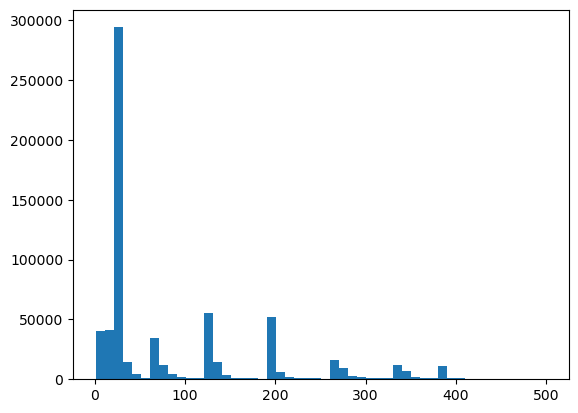

In [36]:
plt.hist(full_seg.flatten(),bins=50,range=(1,500))
plt.show()

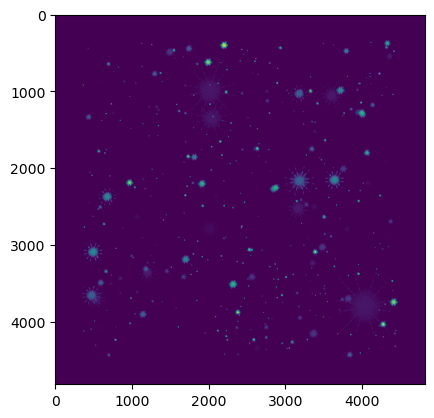

In [37]:
plt.imshow(full_seg)

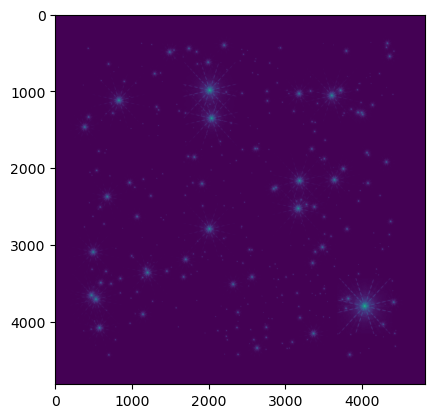

In [24]:
plt.imshow(np.log10(full_image+.01))

In [3]:
roman_base_dir = os.getenv('HOME')+'/Dropbox/RomanGRS/products/'
star_image_dir = os.getenv('HOME')+'/Dropbox/RomanGRS/star_images/'
ready_fits = roman_base_dir+"FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
direct_fits_out = star_image_dir + 'ra0dec0_SCA1.fits'
direct_fits_out_nopad = star_image_dir + 'ra0dec0_SCA1_nopad.fits'
ref_fits_out = star_image_dir + 'ref_ra0dec0_SCA1.fits'
empty_seg = star_image_dir +"empty_seg.fits"
nopad_seg = star_image_dir +"seg_nopad.fits"
empty_direct = star_image_dir +"empty_direct.fits"

In [39]:
hdu = fits.PrimaryHDU(data=full_image)
hdul = fits.HDUList([hdu])
#hdul[0].header["INSTRUME"] = "ROMAN"
hdul[0].header["FILTER"] = "f140w"
hdu.writeto(ref_fits_out, overwrite=True)

In [40]:
file = fits.open(direct_fits_out)
file[1].data = file[1].data[pad:-pad,pad:-pad]
print(file[1].data.shape)
file.writeto(direct_fits_out_nopad, overwrite=True)
file.close()

(4088, 4088)


In [10]:
hdu = fits.PrimaryHDU(data=full_seg[pad:-pad,pad:-pad])
hdul = fits.HDUList([hdu])
hdu.writeto(nopad_seg, overwrite=True)
#hdu.close()

In [ ]:
file = fits.open(ready_fits)
#file[1].data = file[1].data
file[1].data = np.rot90(file[1].data, k=3) # np.rot90 rotates clockwise k times

file[0].header["INSTRUME"] = "ROMAN"
file[0].header["FILTER"] = "d1_"
file[1].header["CONFFILE"] = roman_base_dir+"configuration/Roman.det1.07242020.conf" # This had to be a path, not just a filename; otherwise, grizli can't find the sensitivity fits

file.writeto(ready_fits, overwrite=True)

file[1].data = np.zeros((4088+2*pad,4088+2*pad))
file.writeto(empty_direct, overwrite=True)

file[1].data = full_image#[pad:-pad,pad:-pad]
print(file[1].data.shape)
file.writeto(direct_fits_out, overwrite=True)



header = file[1].header # We need to copy this header info into the segmentation file

file.close()

(4818, 4818)


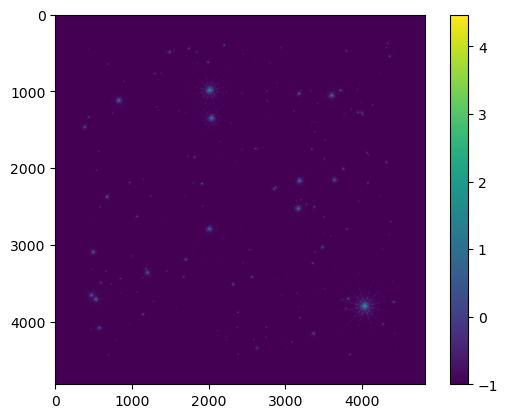

In [17]:
test = fits.open(direct_fits_out)
plt.imshow(np.log10(test[1].data+0.1))
plt.colorbar()

In [35]:
#construct a segmentation map from the direct image
#copied from example here https://photutils.readthedocs.io/en/stable/segmentation.html#image-segmentation
from photutils.background import Background2D, MedianBackground
nopad_image_fromfile = fits.open(direct_fits_out_nopad)[1].data
threshold = 0.01
from photutils.segmentation import detect_sources
segment_map = detect_sources(nopad_image_fromfile, threshold, npixels=10)

In [37]:
from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(nopad_image_fromfile, segment_map,
                               npixels=10, nlevels=32, contrast=0.001,
                               progress_bar=False)

5218


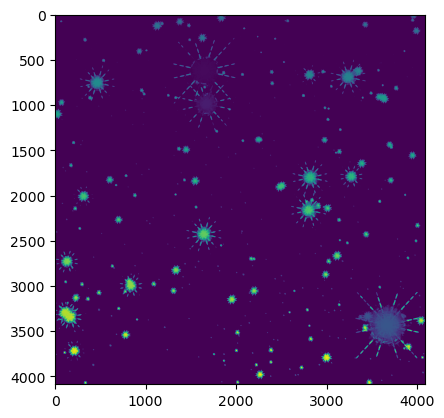

In [38]:
print(len(segm_deblend.labels))
plt.imshow(segm_deblend.data)

In [11]:
len(stars00),len(np.unique(stars00['index']))#.dtype.names

(409, 409)

In [39]:
len(np.unique(segment_map.data))

2406

In [40]:
segmap_db_val = segm_deblend.data
missed_ids = []
found_ids = []
found_segids = []
found_mags = []
nt = 0
for row in stars00:
    ind = row["index"]
    x_0 = row["Xpos"] #+ pad
    y_0 = row["Ypos"] #+ pad
    segid = segmap_db_val[int(x_0)][int(y_0)]
    #segid = segmap_db_val[int(y_0)][int(x_0)]
    if segid != 0 and ~np.isin(segid,found_segids):
        found_ids.append(ind)
        found_segids.append(segid)
        found_mags.append(row["magnitude"])
    nt += 1

In [41]:
len(found_ids)

403

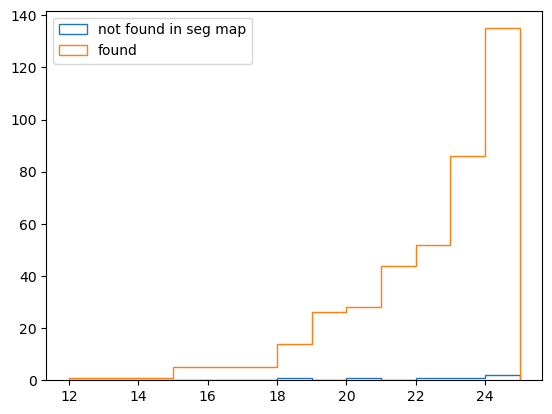

In [20]:
sel_found = np.isin(stars00['index'],found_ids)
plt.hist(stars00[~sel_found]["magnitude"],label='not found in seg map',bins=13,range=(12,25),histtype='step')
plt.hist(stars00[sel_found]["magnitude"],bins=13,range=(12,25),histtype='step',label='found')
plt.legend()
plt.show()

In [5]:
from grizli.model import GrismFLT
#roman = GrismFLT(grism_file=roman_base_dir+'roman_empty.fits',direct_file=direct_fits_out_nopad,ref_file=ref_fits_out, seg_file=None, pad=pad)
#Get WCS info correct for ref file and it might work; make padding smaller
roman = GrismFLT(grism_file=roman_base_dir+'roman_empty.fits',direct_file=direct_fits_out_nopad, seg_file=None)#, pad=pad)
#roman = GrismFLT(grism_file=roman_base_dir+'roman_empty.fits',ref_file=ref_fits_out, seg_file=None, pad=pad)

In [6]:
#masked_seg = np.copy(segmap_db_val)
#mask = np.isin(masked_seg,found_segids)
#masked_seg[~mask] = 0
#masked_seg = full_seg[pad:-pad,pad:-pad]
testf = fits.open(nopad_seg)
#np.array_equal(masked_seg,testf[0].data)
masked_seg = testf[0].data

In [16]:
roman

In [7]:
roman.seg = masked_seg.astype("float32")
#padded_seg = np.pad(masked_seg, [pad, pad], mode='constant')
#roman.seg = padded_seg.astype("float32")

In [47]:
roman.seg.shape

(4088, 4088)

In [76]:
len(np.unique(roman.seg))

404

In [20]:
SED_dir = roman_base_dir+"FOV0/SEDs/" # Change to your path to directory containing SEDs

# Create F158 Filter Bandpass object
df = Table.read(os.path.join(SED_dir, "wfirst_wfi_f158_001_syn.fits"), format='fits') #close to H-band
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

In [18]:

minlam = 1e4
maxlam=2e4
github_dir='/Users/ross.1333/Documents/GitHub/'
tempdir = github_dir+'star_fields/data/SEDtemplates/'
templates = open(github_dir+'star_fields/data/SEDtemplates/input_spectral_STARS.lis').readlines()
temp_inds = stars00['star_template_index'] - 58*(stars00['star_template_index']//58)

In [21]:
count = 0
#for (segid,photid) in zip(found_segids,found_ids):
for i in range(0,len(stars00)):
    #sel_row = stars00['index'] == photid
    photid = i+1
    row = stars00[i]#stars00[sel_row]
    mag = row["magnitude"]#[0]
    temp_ind = int(temp_inds[i])#[sel_row])[0])#int(row['star_template_index'][0])
    #print(temp_ind)
    star_type = templates[temp_ind].strip('\n')
    temp = np.loadtxt(tempdir+star_type).transpose()
    wave = temp[0]
    sel = wave > minlam
    sel &= wave < maxlam
    wave = wave[sel]
    flux = temp[1]
    flux = flux[sel]
    star_spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstroms", fluxunits="flam")
    spec = star_spec.renorm(mag, "abmag", bp)
    spec.convert("flam")


    # By default, grizli trys to compute a cutout size. This cutout size is not large enough for the roman grism.
    # In 4) FOV0_sims/notebooks/dy-by-optimize.ipynb, I estimate the maximum needed size to be 77 for detector 1.
    # See that notebook for more details
    #segid changed to photid with new seg map
    roman.compute_model_orders(id=photid, mag=mag, compute_size=False, size=77, in_place=True, store=False,
                               is_cgs=True, spectrum_1d=[spec.wave, spec.flux])
    count += 1
    print(count)
    #if count%100 == 0:
    #    print('done with '+str(count)+' of '+str(len(np.unique(masked_seg))))#str(len(found_segids)))

1
2
3
4
ID 5 not found in segmentation image
5
6
7
ID 8 not found in segmentation image
8
9
10
ID 11 not found in segmentation image
11
12
13
14
15
16
17
18
19
20
21
22
23
ID 24 not found in segmentation image
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
ID 58 not found in segmentation image
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
ID 89 not found in segmentation image
89
90
91
ID 92 not found in segmentation image
92
93
94
95
96
ID 97 not found in segmentation image
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
ID 130 not found in segmentation image
130
131
132
133
134
135
136
ID 137 not found in segmentation image
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
ID 163 not found in segmentation image
163
164
165
166
167
168
169
170
171
172
1

In [54]:
stars00[0]['index']

17.0

In [ ]:
for photid in range(1,len(np.unique(masked_seg))):
    sel_row = stars00['index'] == photid
    row = stars00[sel_row]
    print(photid,len(row))

1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 1
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 1
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 1
51 1
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 1
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 1
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 1
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 1
109 0
110 0
111 0
112 0
113 0
114 1
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 1
128 0
129 0
130 1
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 1
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 0
184 0
185 

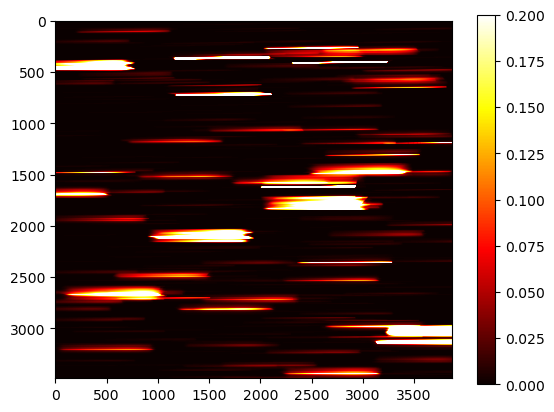

In [22]:
#plt.imshow(roman.model, vmax=0.2, cmap="hot")
plt.imshow(roman.model[pad:-pad, pad:-pad], vmax=0.2, cmap="hot")
plt.colorbar()

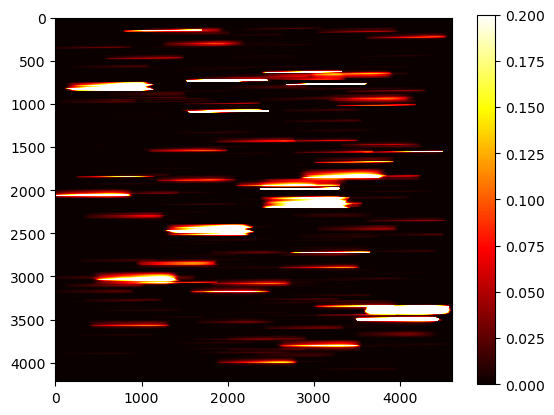

In [23]:
plt.imshow(roman.model, vmax=0.2, cmap="hot")
plt.colorbar()

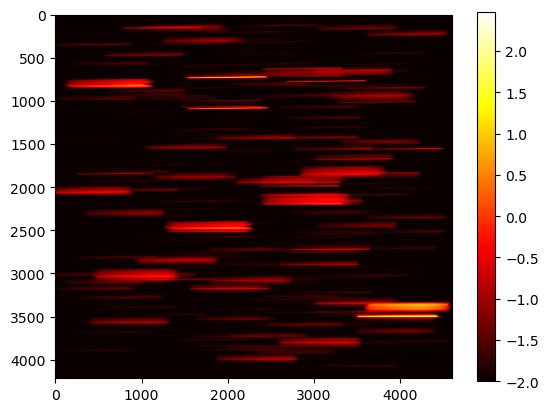

In [29]:
plt.imshow(np.log10(roman.model+0.01), cmap="hot")#, vmax=0.2, cmap="hot")
plt.colorbar()

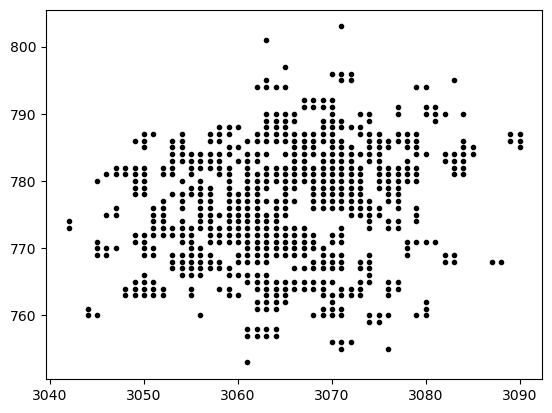

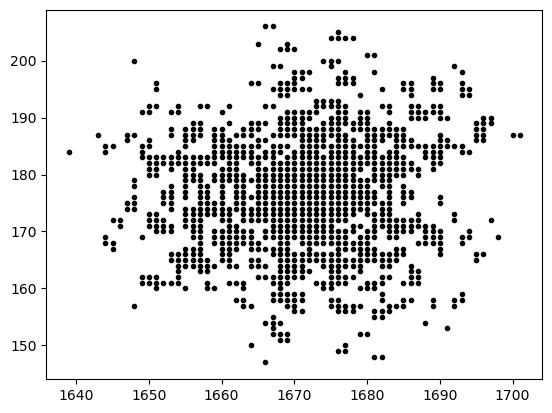

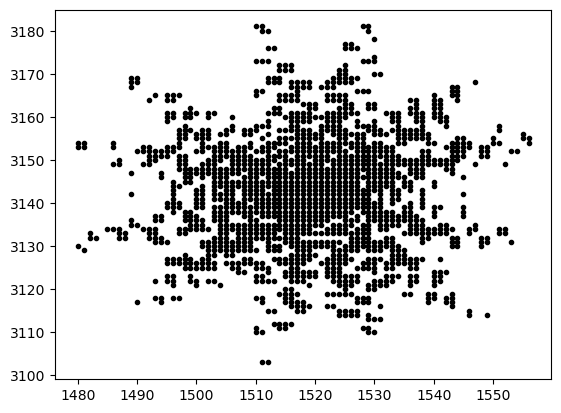

In [81]:
a = np.where(roman.seg == 9)
plt.plot(a[0],a[1],'k.')
plt.show()

a = np.where(roman.seg == 8)
plt.plot(a[0],a[1],'k.')
plt.show()

a = np.where(roman.seg == 7)
plt.plot(a[0],a[1],'k.')
plt.show()

In [70]:
xval = [12,13,14]
yval = [16,17,18]
roman.model[xval,yval]

array([0., 0., 0.], dtype=float32)

In [75]:
def get1d_spec(image,segind,minl=1e4,maxl=2e4,res=25,minx=-400,maxx=599):
    #~12 angstroms per pixel
    nbin = int((maxl-minl)*1.0001/res)
    fluxl = np.zeros(nbin)
    npixl = np.zeros(nbin)
    segv = np.where(image.seg==segind)#image.seg.nonzero()
    lamvl = np.arange(minl+res/2.,maxl,res)
    dxv = np.arange(minx,maxx)
    print(len(dxv),min(dxv),max(dxv))
    for i in range(0,len(segv[0])):
        #print(i,len(segv[0]))
        xp = segv[1][i]
        yp = segv[0][i]
        #print(xp,yp)
        #for dx1 in range(minx,maxx):
            #dx = (dx1,dx1+1)
            #dy, lam = image.conf.get_beam_trace(x=xp-image.pad, y=yp-image.pad, dx=dx, beam='A')
            #print(dx1,dy,lam)
        dyv, lamv = image.conf.get_beam_trace(x=xp-image.pad[0], y=yp-image.pad[1], dx=dxv, beam='A')
        #dxv = dx1
        #print(dyv)
        #print(lamv)
        #for lamv,dyv,dxv in zip(lam,dy,dx):
            #print(lamv,dyv,dxv)
        #if lamv > minl and lamv < maxl:
        sellam = (lamv > minl)
        sellam &= lamv < maxl
        ypf = (dyv[sellam]+yp).astype(int)#int(yp+dyv)
        xpf = (dxv[sellam]+xp).astype(int)#int(xp+dxv)
        sel_im = ypf < len(image.model[0])
        sel_im &= xpf < len(image.model[0])
        #if ypf < len(image.model[0]) and xpf < len(image.model[0]):
        modv = image.model[ypf,xpf]
        binv = ((lamv[sellam]-minl)/res).astype(int)
        fluxl[binv] += modv
        npixl[binv] += 1.
                        #print(lamv,modv,ypf,xpf)
                    #else:
                    #    print(segv,ypf,xpf)
    return lamvl,fluxl,npixl

In [76]:
res = get1d_spec(roman,9)

999 -400 598


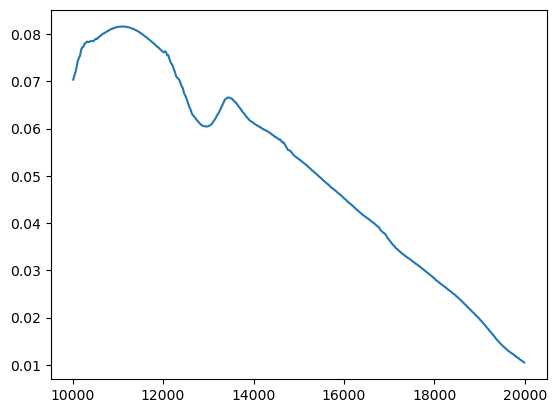

In [79]:
plt.plot(res[0],res[1]/res[2])

In [ ]:
#segx = []
m,n = segmap_db_val.shape
R,C = np.mgrid[:m,:n]
segxyz = np.column_stack((C.ravel(),R.ravel(), segmap_db_val.ravel())).transpose()

In [24]:
m,n = masked_seg.shape
R,C = np.mgrid[:m,:n]
segxyz = np.column_stack((C.ravel(),R.ravel(), masked_seg.ravel())).transpose()

In [26]:
sel = segxyz[2] == 5
print(np.min(segxyz[0][sel]),np.max(segxyz[0][sel]),segxyz[1][sel])
print(stars00['Ypos'][4],stars00['Xpos'][4])

95 336 [3604 3605 3609 ... 3839 3839 3840]
214.01446397300785 3722.7311551647904


In [ ]:
full_image_nopad = full_image[pad:-pad,pad:-pad]

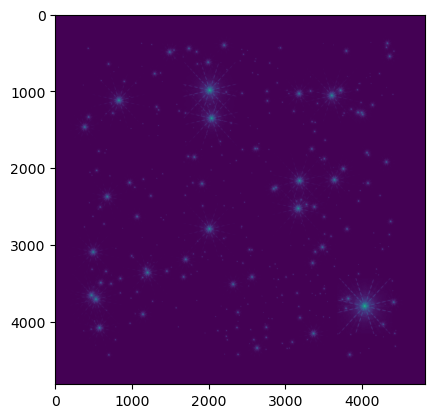

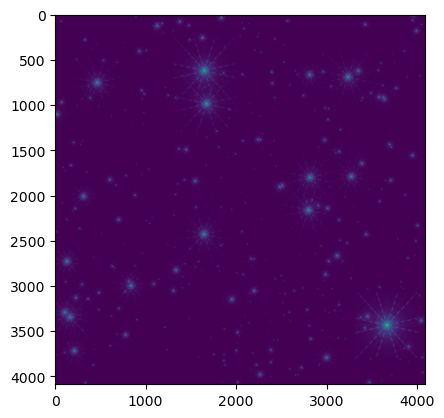

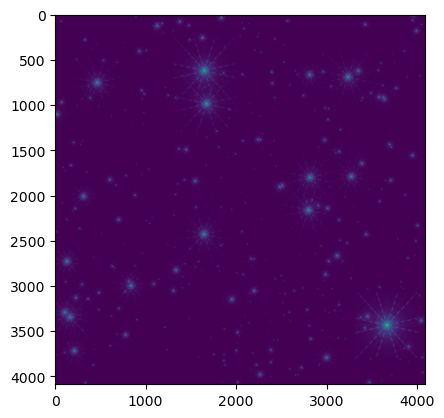

In [34]:
plt.imshow(np.log(full_image+0.01))
plt.show()
plt.imshow(np.log(full_image_nopad+0.01))
plt.show()
test = fits.open(direct_fits_out)
plt.imshow(np.log(test[1].data+0.01))
plt.show()

In [35]:
np.array_equal(full_image_nopad,test[1].data)

True

In [36]:
#m,n = full_image.shape
#R,C = np.mgrid[:m,:n]

full_image_xyz = np.column_stack((C.ravel(),R.ravel(), full_image_nopad.ravel())).transpose()

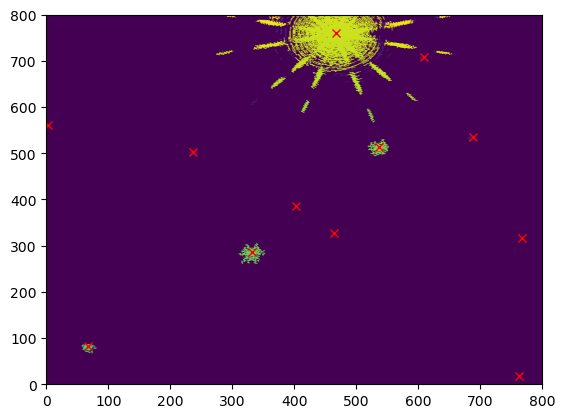

In [37]:
xmin = 0
xmax = 800
ymin = 0
ymax = 800
sel =  segxyz[0] >= xmin
sel &= segxyz[0] < xmax
sel &= segxyz[1] < ymax
sel &= segxyz[1] >= ymin
plt.scatter(segxyz[0][sel],segxyz[1][sel],c=segxyz[2][sel],s=.1)
#plt.scatter(full_image_xyz[0][sel]+.5,full_image_xyz[1][sel]+.5,c=np.log(full_image_xyz[2][sel]+0.01),s=.1)
plt.plot(stars00['Ypos'],stars00['Xpos'],'rx')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.show()

In [38]:
sel = stars00['Xpos'] < 100
sel &= stars00['Ypos'] < 100
stars00[sel]

index,Xpos,Ypos,8,8again,0,star_template_index,0again,magnitude,0again2,1,0again3,0again4,mag_again,RA,DEC
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
774.0,82.25625288137611,67.03272411942329,8.0,8.0,0.0,129.0,0.0,22.0,0.0,1.0,0.0,0.0,22.0,0.2625365459155007,-0.2629989434881002


In [39]:
len(found_ids),nt#,found_mags

(403, 409)

In [40]:
from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(full_image, segment_map,
                               npixels=10, nlevels=32, contrast=0.001,
                               progress_bar=False)

ValueError: The data and segmentation image must have the same shape

In [ ]:
print(len(segm_deblend.labels))

In [ ]:
# Maybe functional amplitdue functions?
f158_lam_center = 1.577 * 10**-6 # micrometer
telarea = 2.36**2 * constants.pi # meter ** 2

f_0 = 3.7059108273831045e-10 # this is just a number that seems to work; theoretically, this is comparable to an ABZeropoint

# Calculate number of counts as a function of magnitude
N = lambda mag: telarea * (f158_lam_center / (constants.h * constants.speed_of_light)) * f_0 * 10**(-0.4 * mag)

N(13.5)
# Exploring Magnitude adjustments and Spectral Source File
#src = webbpsf.specFromSpectralType('G0V', catalog='phoenix')
src = {'wavelengths': [1.5e-6], 'weights': [1.]}

wavelength = 1.5e-6
wfi.detector_position = (4, 4)
psf_0_0 = wfi.calc_psf(monochromatic=wavelength, fov_pixels=364, oversample=2)#.calc_psf(normalize='last', fov_pixels=364, oversample=2, source=src)
print(psf_0_0[0].data.sum())
factor = N(13.5)

vmin = 1e-7 * factor
vmax = 0.1 * factor
psf_0_0[0].data *= factor
plt.imshow(psf_0_0[0].data, interpolation='nearest', origin='lower', norm=LogNorm(vmin=vmin, vmax=vmax), cmap='hot')
psf_0_0[0].data.max()

Below shows quick derivation of assumed zero point in 2022 sims

In [ ]:
img = fits.open(direct_fits)[1].data
#this section contains a mag 13.5 star
plt.imshow(np.log(img)[1374:1474,1900:2000])#[1900:2000,1374:1474])
sumflux = np.sum(img[1374:1474,1900:2000]-0.25)
mag = 26.5 - 2.5*np.log10(sumflux)
print(sumflux,mag)
plt.colorbar()
plt.show()
#this section contains a mag 16 star
plt.imshow(np.log(img)[3094:3194,1966:2066])#[1900:2000,1374:1474])
sumflux = np.sum(img[3094:3194,1966:2066]-0.25)
mag = 26.5 - 2.5*np.log10(sumflux)
print(sumflux,mag)
plt.colorbar()
plt.show()

In [ ]:
hlss_tbl = Table.read(roman_base_dir+"FOV0/roll_0/dither_0x_0y/SCA1/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt", format="ascii")

In [ ]:
hlss_tbl.dtype.names

In [ ]:
sel = (hlss_tbl['MODIMAGE'] == 1)

In [ ]:
hlss_tbl[sel]

In [66]:
file = fits.open('/Users/ross.1333/Dropbox/RomanGRS/data_4grizli_tests/hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits')

In [68]:
file.info()

Filename: /Users/ross.1333/Dropbox/RomanGRS/data_4grizli_tests/hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (5250, 5250)   float32   


In [69]:
file[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5250                                                  
NAXIS2  =                 5250                                                  
EXTEND  =                    T                                                  
DATE    = '2013-03-22T012:00:00'                                                
FILETYPE= 'SCI     '           / type of data found in data file                
TELESCOP= 'HST     '           / telescope used to acquire data                 
INSTRUME= 'WFC3    '           / identifier for instrument used to acquire data 
EQUINOX =               2000.0 / equinox of celestial coord. system             
EXPTIME =                  1.0 / exposure duration (seconds)--calculated        
OBSTYPE = 'IMAGING '        

/var/folders/cp/534_82795637qs_pz7j2m5hc0000gp/T/ipykernel_26505/4115083819.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(file[0].data+0.01))
/var/folders/cp/534_82795637qs_pz7j2m5hc0000gp/T/ipykernel_26505/4115083819.py:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(file[0].data+0.01))


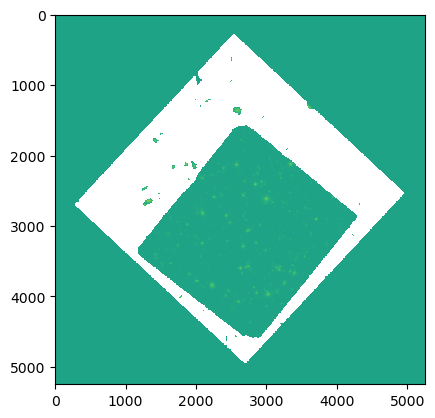

In [56]:
plt.imshow(np.log(file[0].data+0.01))

In [61]:
file = fits.open(direct_fits_out)

In [59]:
file.info()

Filename: /Users/ross.1333/Dropbox/RomanGRS/star_images/ref_ra0dec0_SCA1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (4818, 4818)   float64   


In [62]:
file[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
INSTRUME= 'ROMAN   '           / instrument name                                
EXPTIME =                141.0 / exposure time                                  
FILTER  = 'd1_     '                                                            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 